# Exploring the UTx000 Extension Beiwe Data
(Known as BPEACE2 in the [GH repo](https://github.com/intelligent-environments-lab/utx000))

# GPS Inspection
The GPS data are a little wonky, so I want to take a closer look.

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Package Import

In [2]:
import sys
sys.path.append('../')

from src.features import build_features
from src.visualization import visualize
from src.reports import make_report

import pandas as pd
import numpy as np

from datetime import datetime, timedelta

import matplotlib.pyplot as plt

# Data Import

## GPS Data
The GPS data are available in the ```processed``` directory

In [3]:
gps = pd.read_csv('../data/processed/bpeace2-gps.csv', index_col=0, parse_dates=True, infer_datetime_format=True)
gps.tail()

,Lat,Long,Alt,Accuracy,X_Distance,Y_Distance,Distance_Home,Beiwe
Time,,,,,,,,
2020-07-08 13:00:00,30.29101,-97.74942,153.70001,13.816,6483.995875,1441.708941,6642.343501,xxvnhauv
2020-07-08 14:05:00,30.29101,-97.74944,153.70001,13.843,6483.995875,1439.485042,6641.861162,xxvnhauv
2020-07-08 15:25:00,30.29101,-97.74945,153.60001,16.086,6483.995875,1438.373093,6641.620259,xxvnhauv
2020-07-08 16:20:00,30.29100,-97.74941,153.60001,18.394,6485.031360,1442.820890,6643.595703,xxvnhauv
2020-07-08 16:30:00,30.29101,-97.74942,153.70001,15.084,6483.995875,1441.708941,6642.343501,xxvnhauv


In [7]:
n = len(gps['Beiwe'].unique())
print(f'Number of Beiwe participants: {n}')

Number of Beiwe participants: 25


## Address Information
We can also take a look at how well the GPS coordinates tend to match up with addresses

In [4]:
info = pd.read_excel('../data/raw/bpeace2/admin/id_crossover.xlsx',sheet_name='beacon')
info.head()

,REDCap,Beiwe,Beacon,start_date,end_date,move_date,return_date,Lat,Long,original_start,original_end,original_move
0,10,kyj367pi,1,2020-06-08,2020-09-03,2020-07-31,2020-09-02,30.312614,-97.732338,2020-06-06,2020-09-03,2020-07-31
1,55,745vq78e,5,2020-06-08,2020-08-23,NaT,2020-09-08,30.288012,-97.751201,2020-06-08,2020-09-09,2020-09-09
2,61,itmylz3g,6,2020-06-15,NaT,NaT,NaT,29.855371,-95.741200,2020-06-15,NaT,2020-09-14
3,0,zdpffrox,7,2020-06-01,2020-09-01,NaT,2020-09-01,30.326815,-97.744665,2020-06-02,2020-09-14,2020-09-14
4,43,xlw5ntd5,10,2020-06-08,2020-09-11,2020-08-10,2020-09-22,30.351693,-97.614524,2020-06-06,NaT,2020-08-10


# Individual-Level Inspection
We want to look at a few individuals to get a sense of the data and what gaps are present. The entire study period is quite long so we can restrict the time frame if need be to get a better look.

In [5]:
gps['Beiwe'].unique()

array(['2xtqkfz1', '4i7679py', '5fvmg226', '745vq78e', '9jtzsuu8',
       '9xmhtq74', 'awa8uces', 'e73a1pd5', 'hcpu5myv', 'hxj6brwj',
       'i31pt4b4', 'idbkjh8u', 'itmylz3g', 'kyj367pi', 'lkkjddam',
       'mm69prai', 'olaxadz5', 'qh34m4r9', 'rnse61g4', 'tlmlq19s',
       'tmexej5v', 'vr9j5rry', 'xdbdrk6e', 'xlw5ntd5', 'xxvnhauv'],
      dtype=object)

Choosing randomly from the list above (first, last, and somewhere in the middle), we can inspect the GPS data. We look at the Lat and Long values for each participant of interest to make sure they match up. 

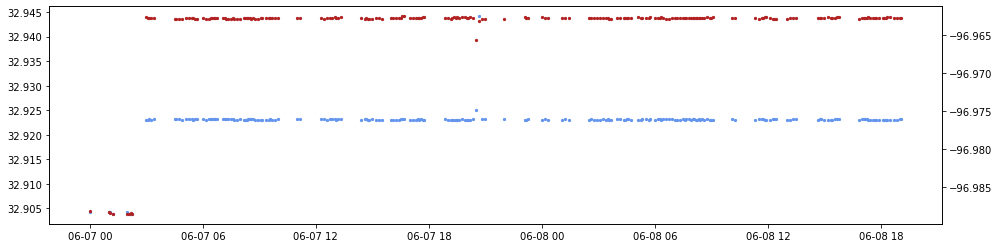

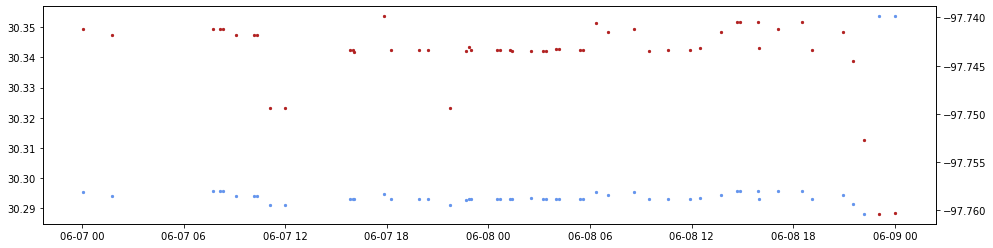

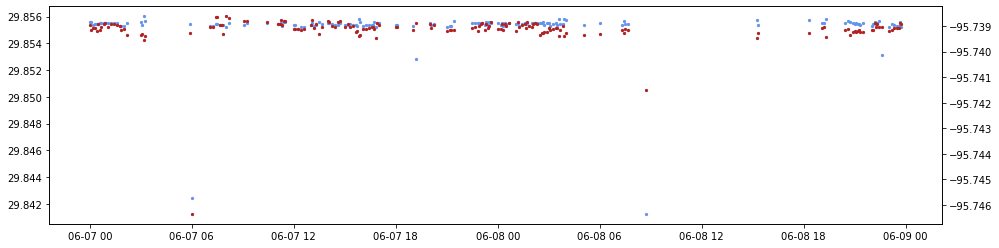

In [54]:
for pt in ['2xtqkfz1','xxvnhauv','itmylz3g']:
    fig, ax_lat = plt.subplots(figsize=(16,4))
    # gps data per individual
    gps_pt = gps[gps['Beiwe'] == pt]
    # restricting again for the date
    gps_pt = gps_pt[datetime(2020,6,7):datetime(2020,6,9)]
    # info per individual
    info_pt = info[info['Beiwe'] == pt]

    # Plotting Lat
    ax_lat.scatter(gps_pt.index,gps_pt['Lat'], color='cornflowerblue', s=5)
    
    # Plotting Long on same axis
    ax_long = ax_lat.twinx()
    ax_long.scatter(gps_pt.index,gps_pt['Long'], color='firebrick', s=5)

    plt.show()
    plt.close()

## Address Coordinate Overlap and Move-Out Dates

Looking at Lat:


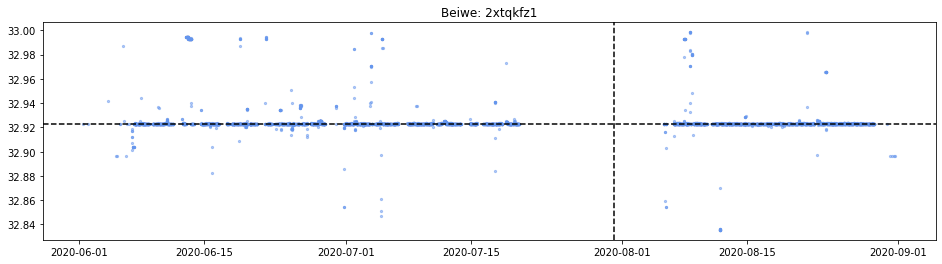

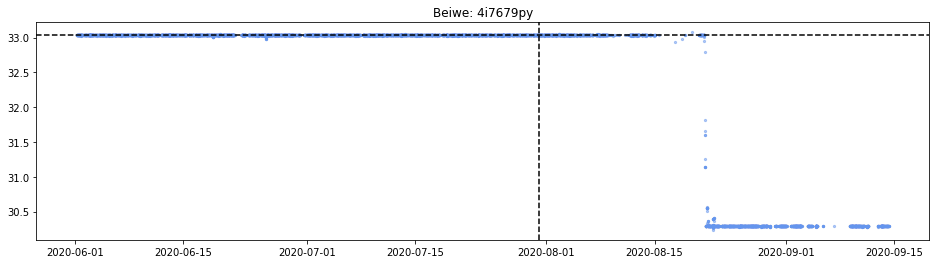

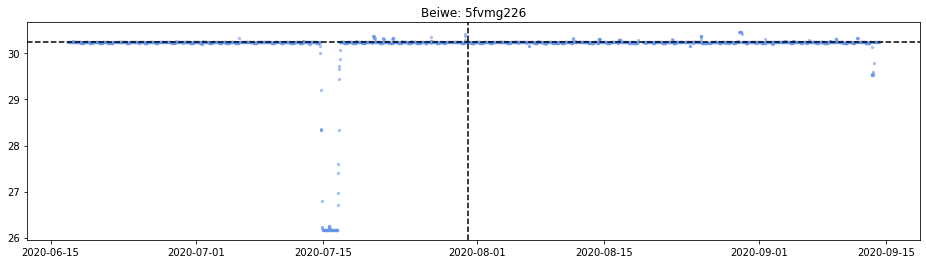

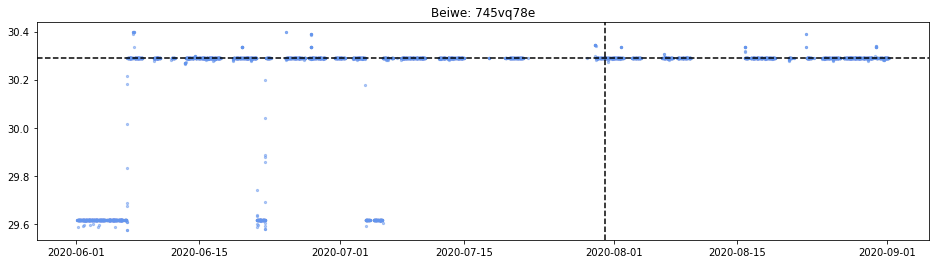

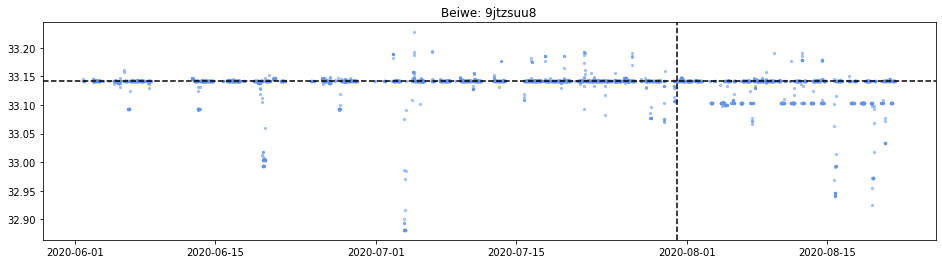

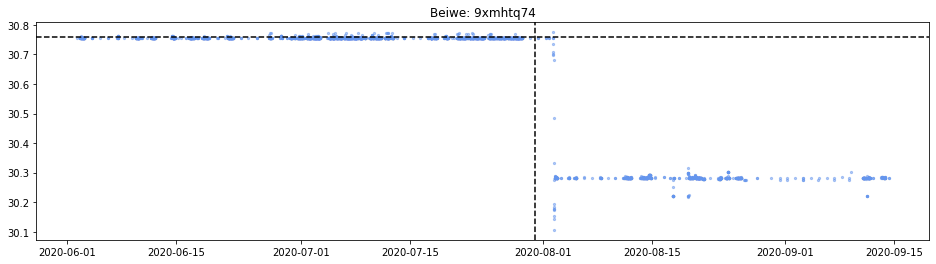

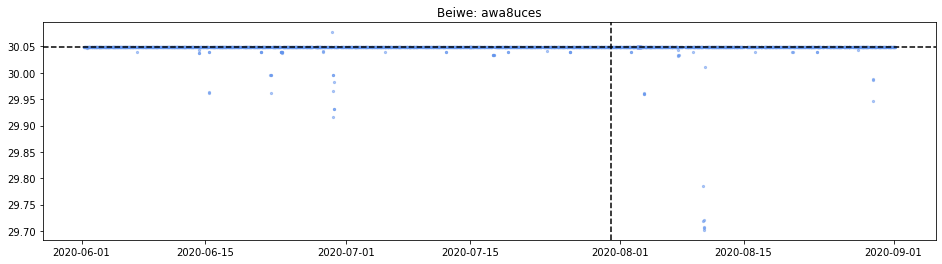

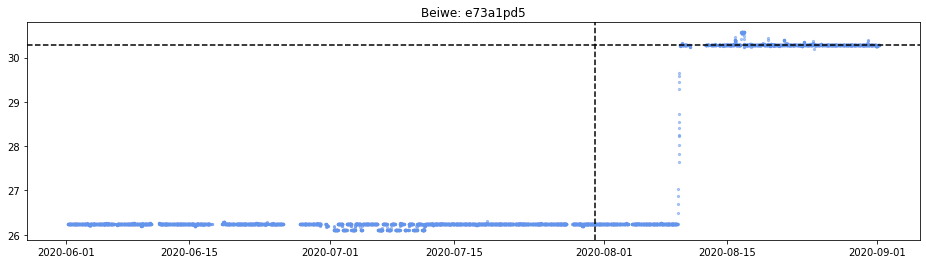

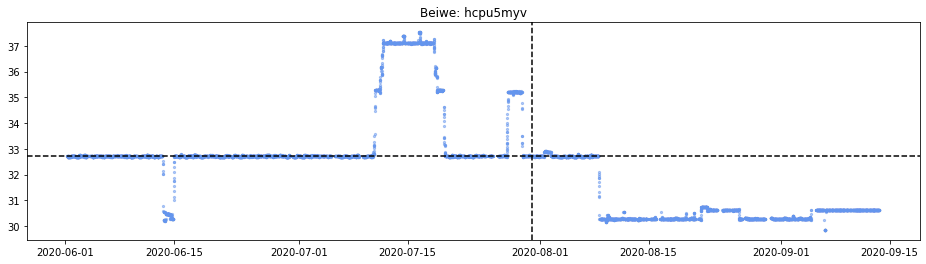

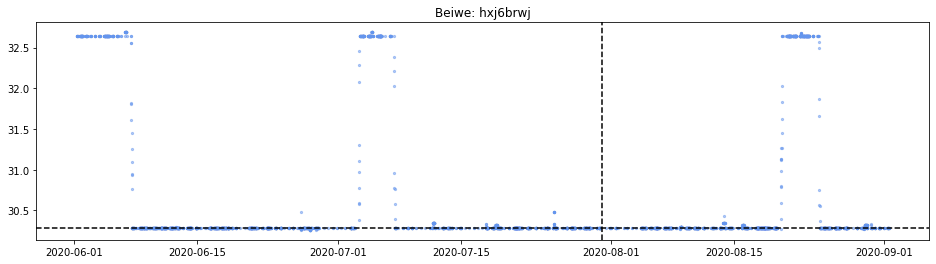

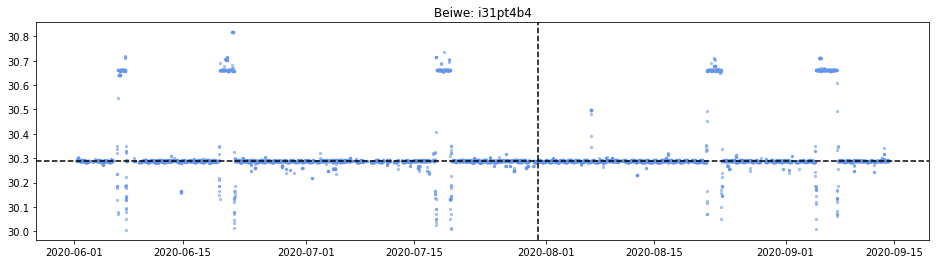

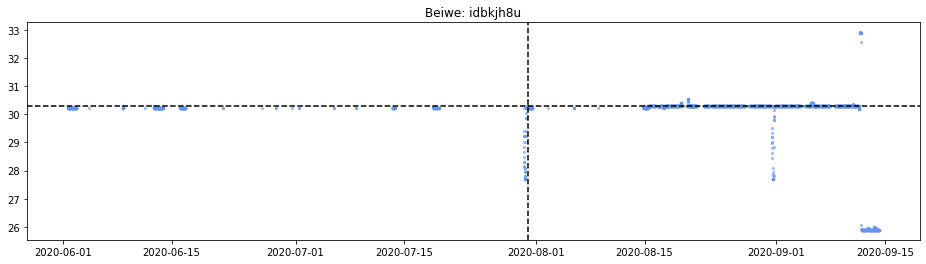

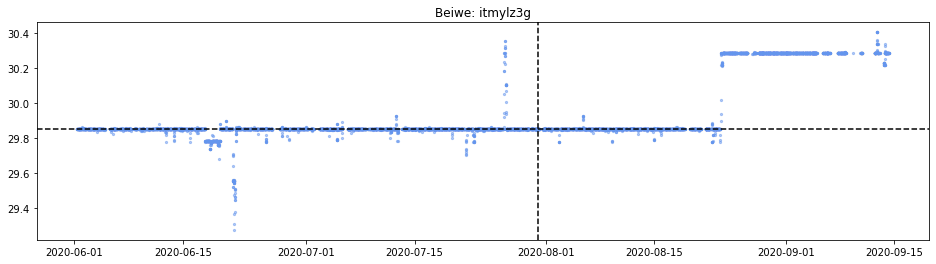

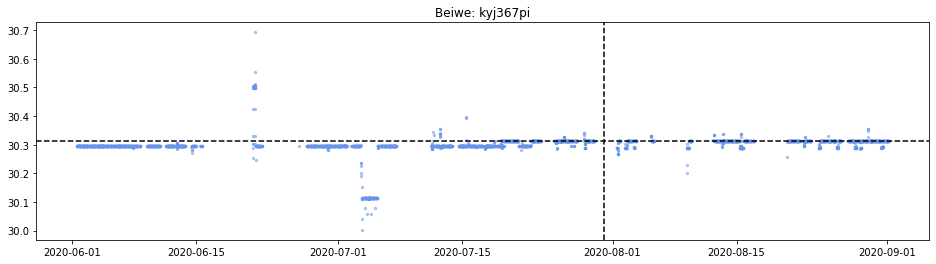

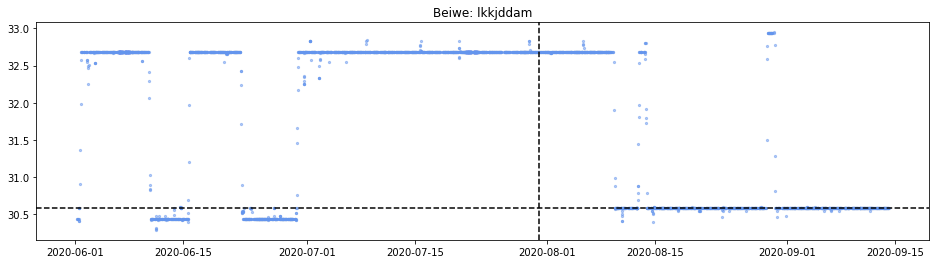

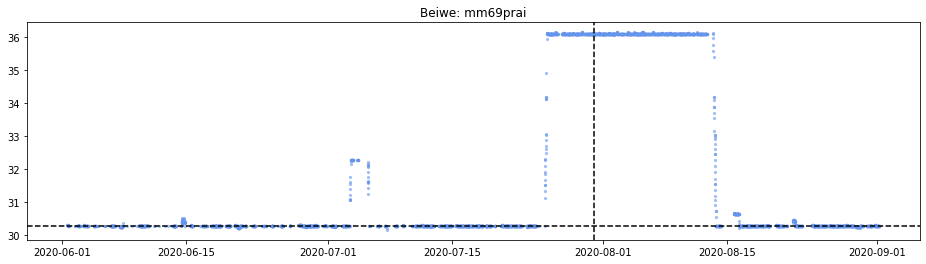

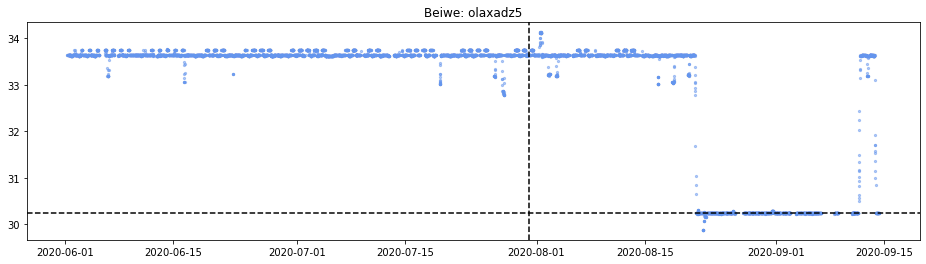

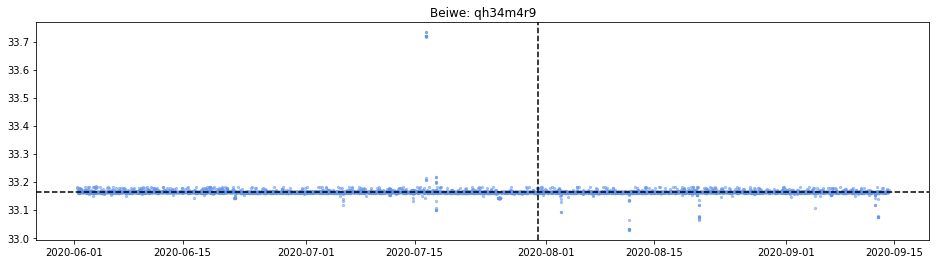

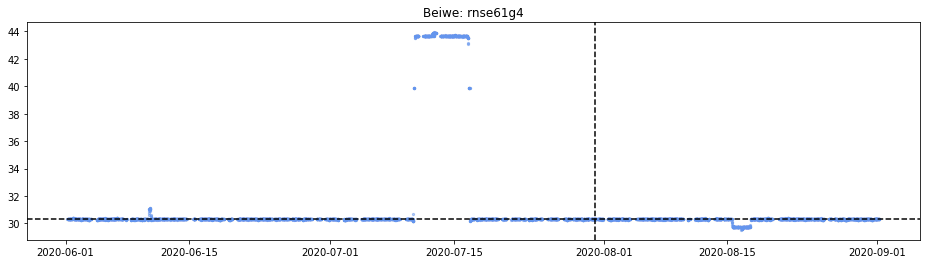

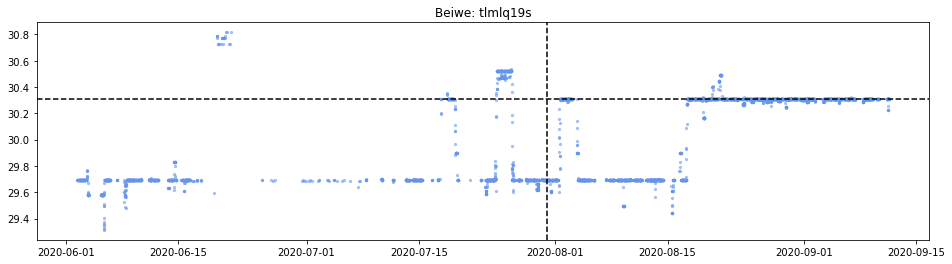

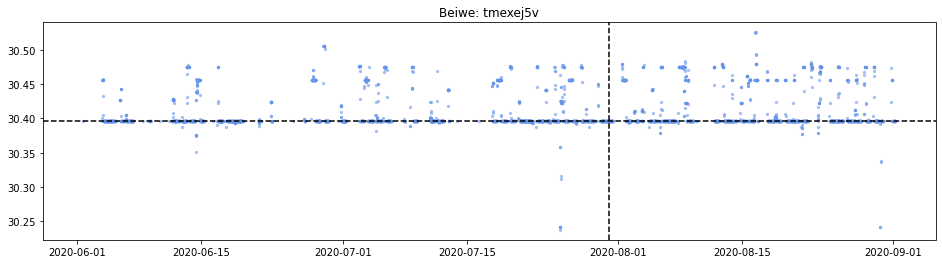

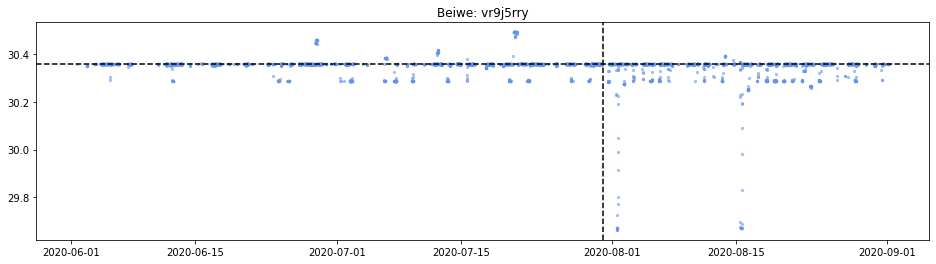

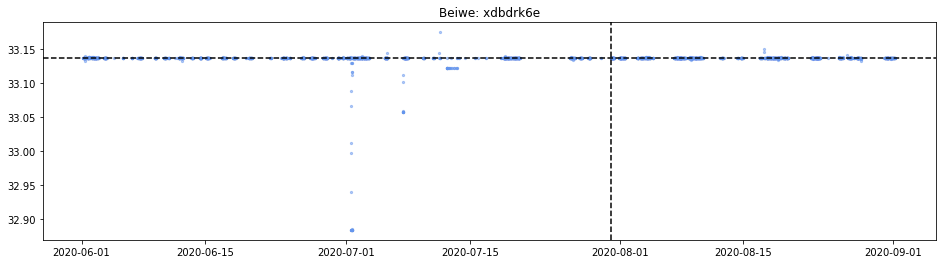

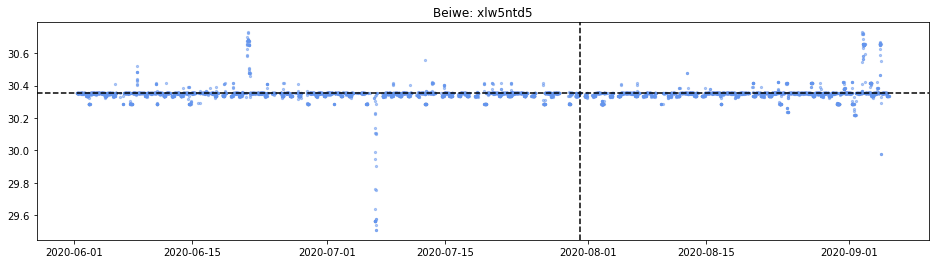

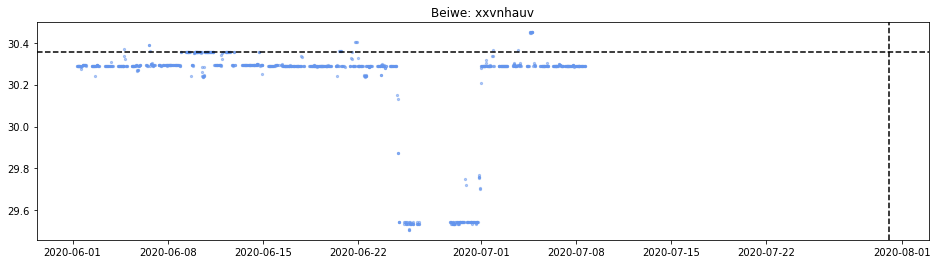

Looking at Long:


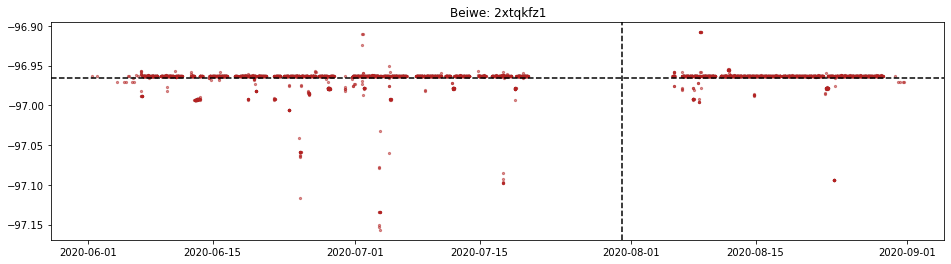

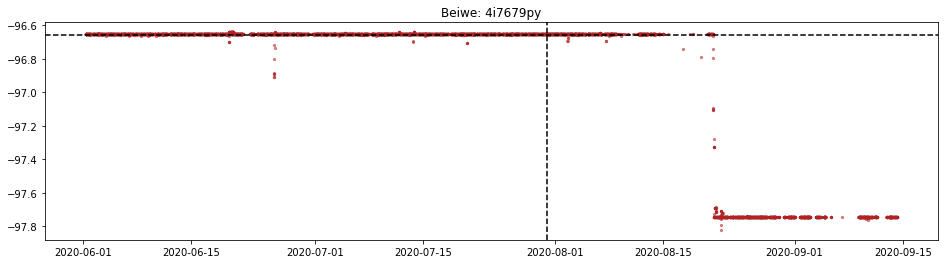

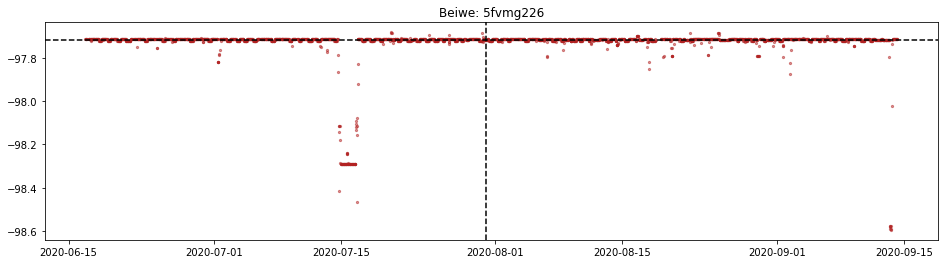

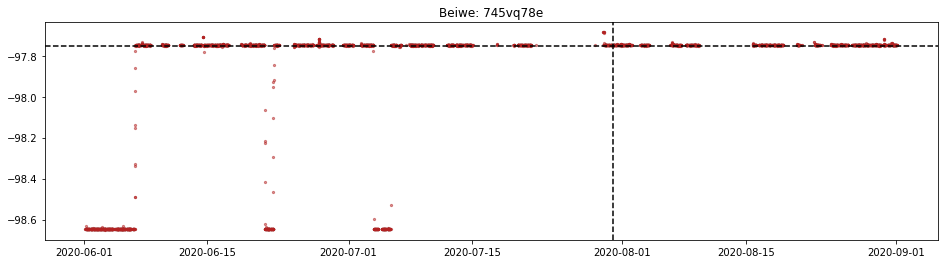

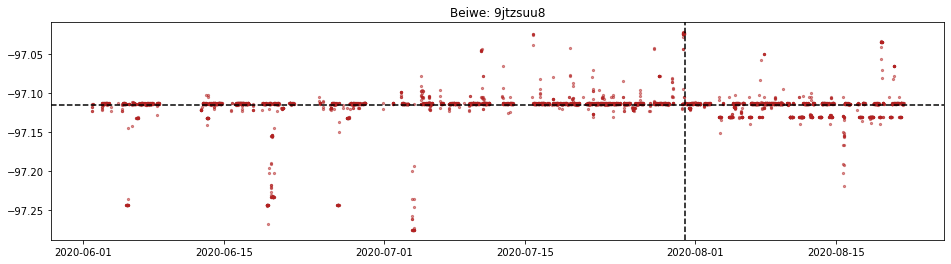

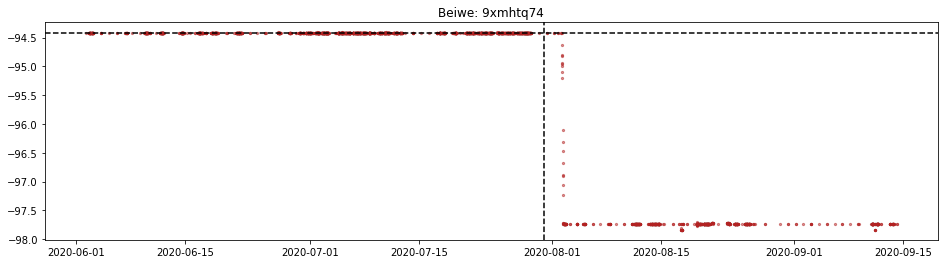

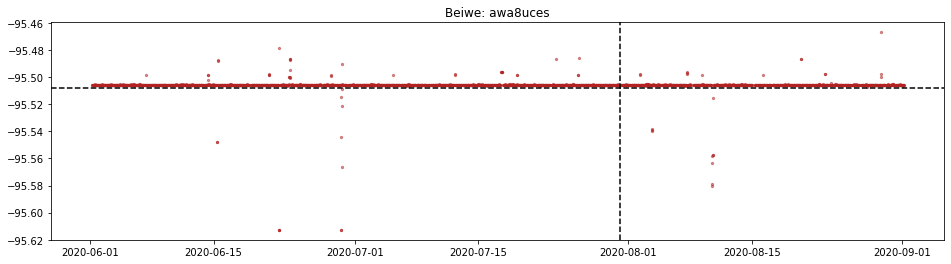

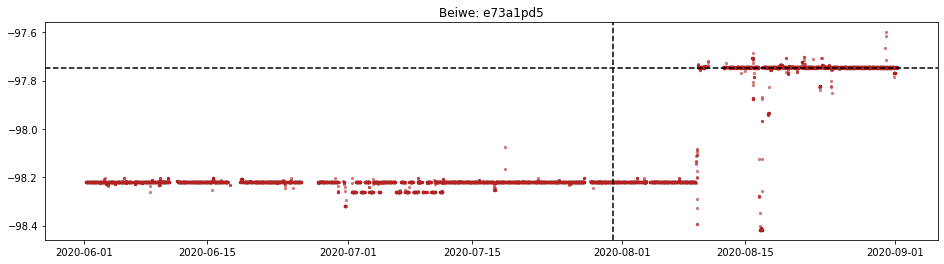

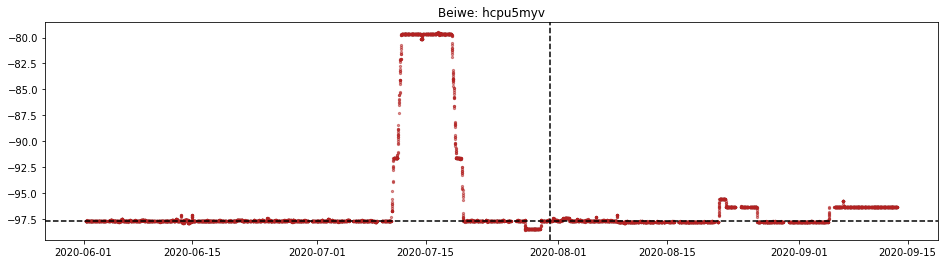

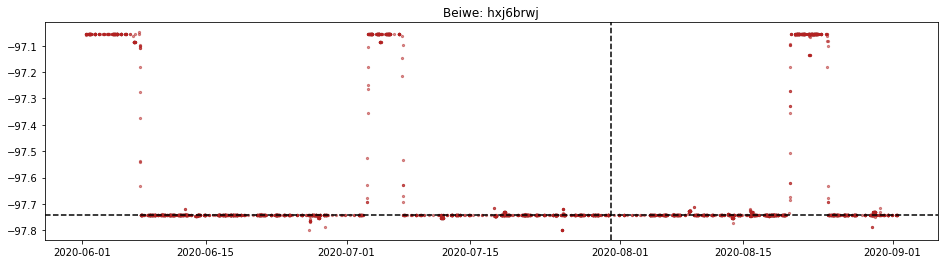

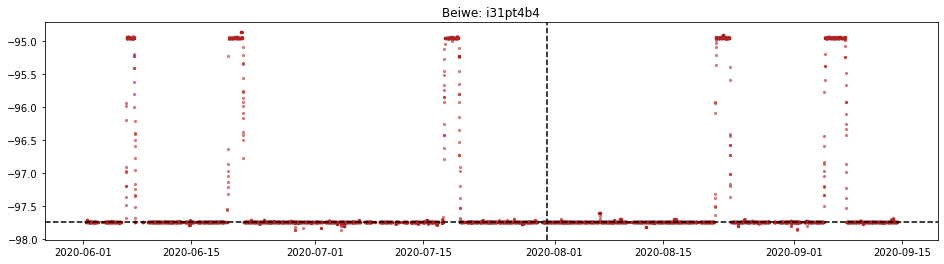

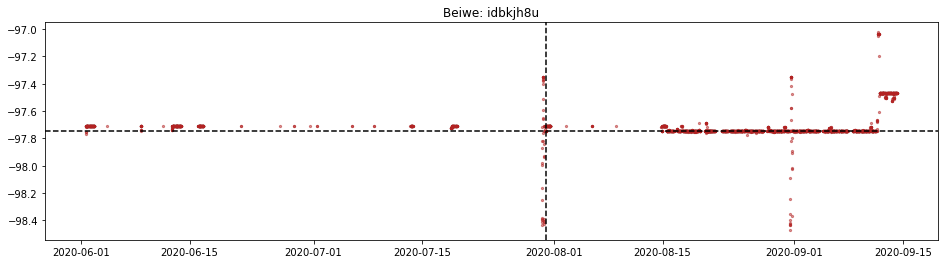

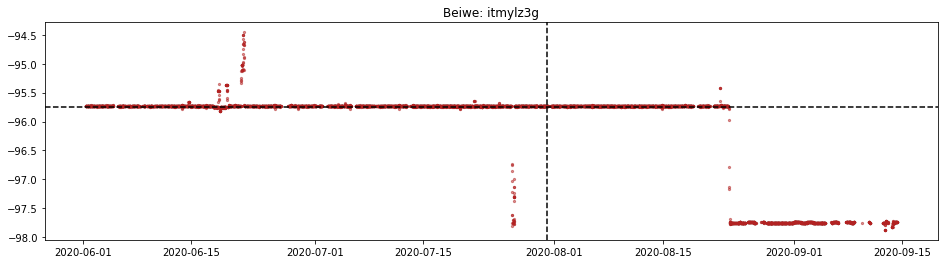

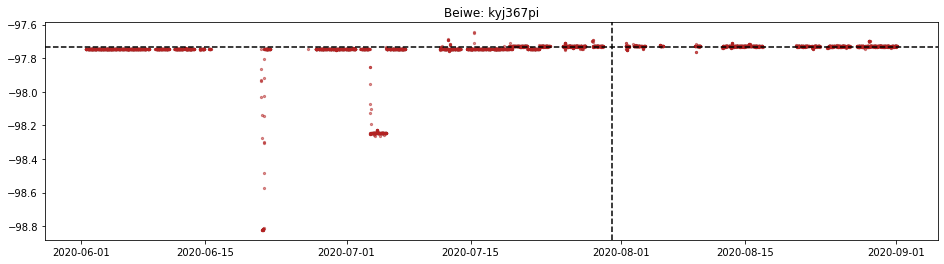

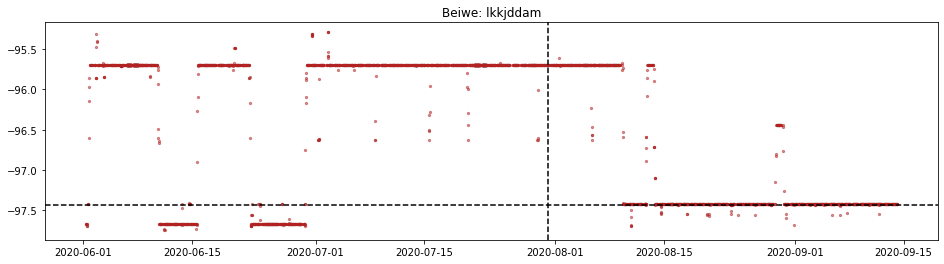

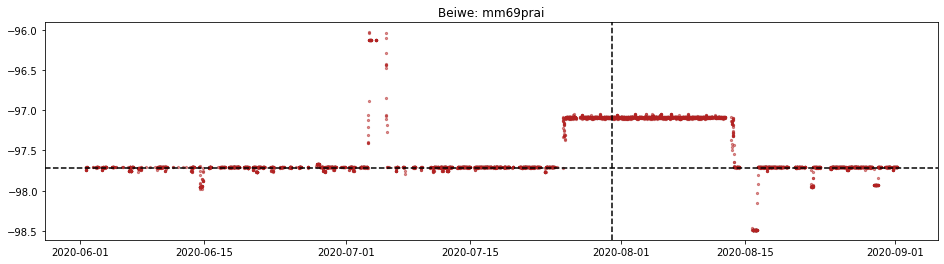

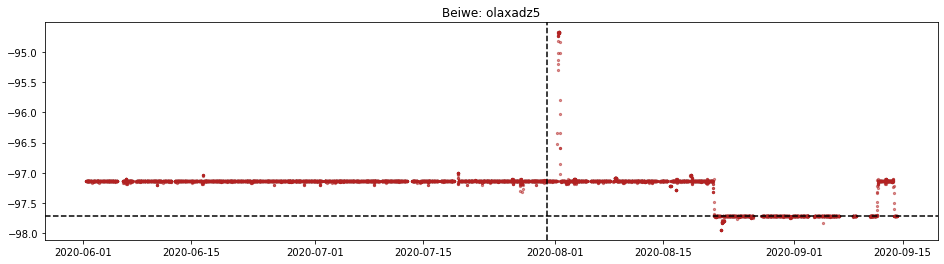

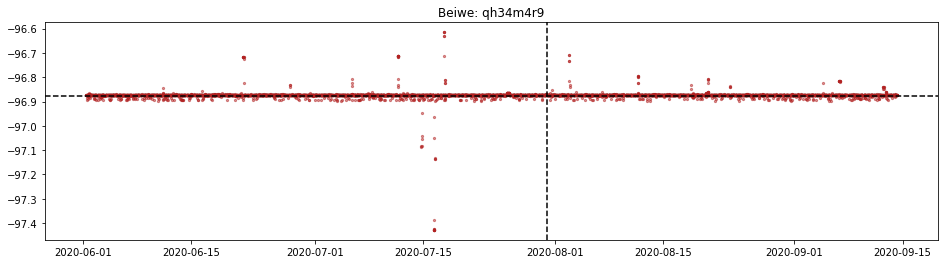

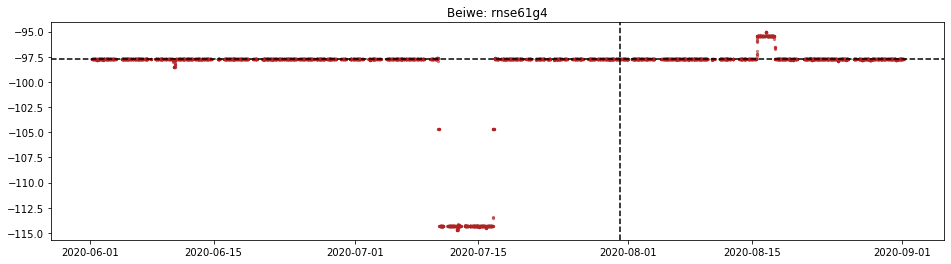

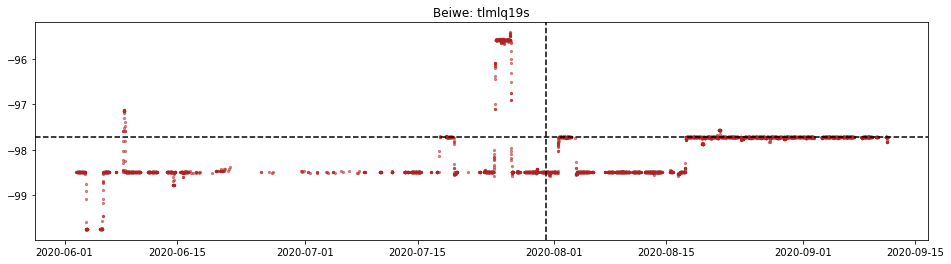

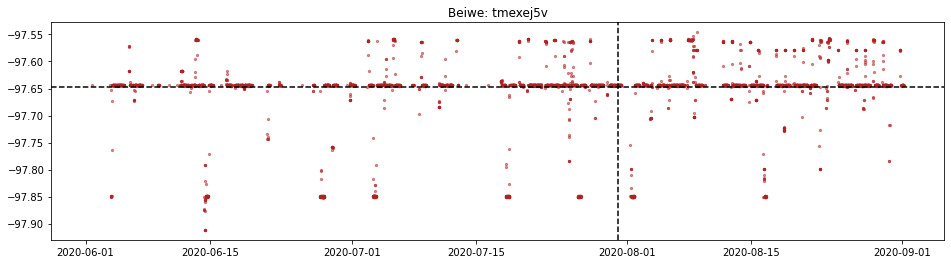

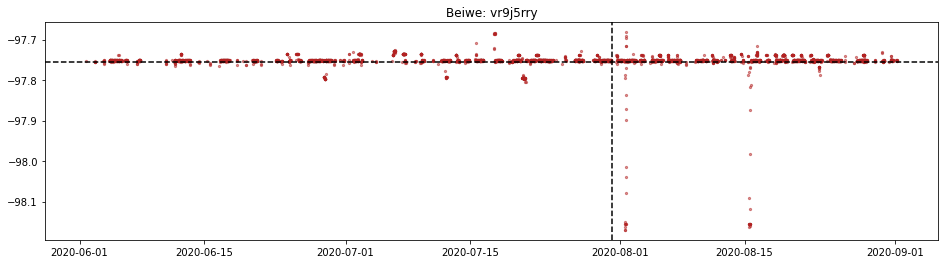

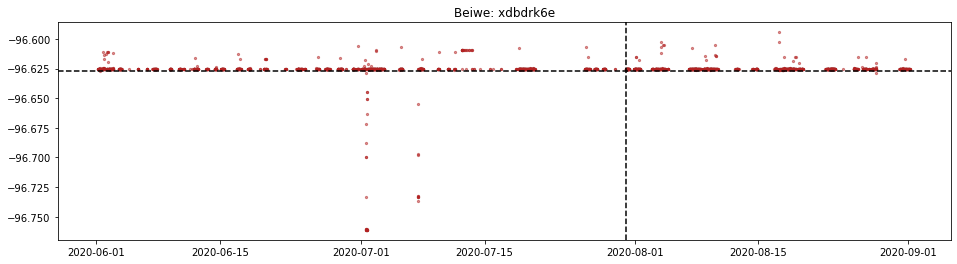

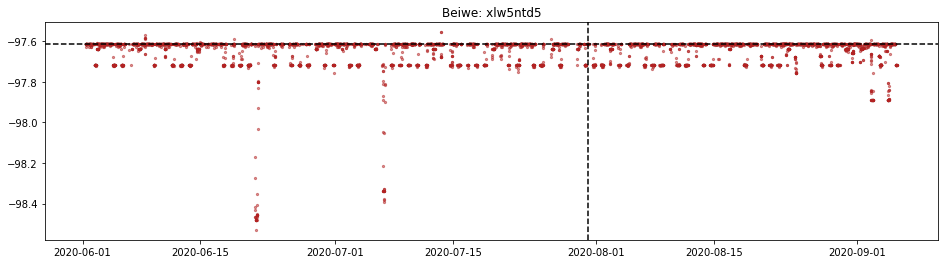

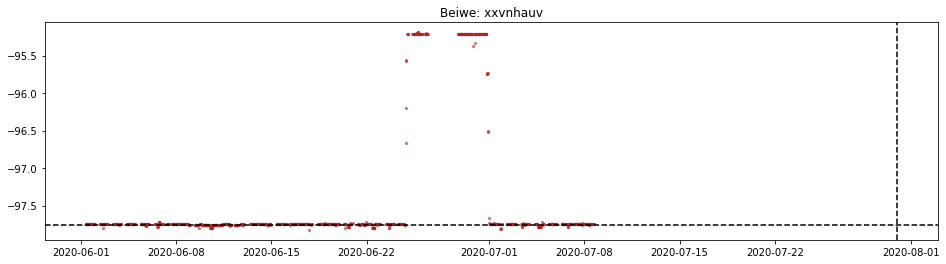

In [65]:
for coord, color in zip(['Lat','Long'],['cornflowerblue','firebrick']):
    print(f'Looking at {coord}:')
    for pt in gps['Beiwe'].unique():
        fig, ax = plt.subplots(figsize=(16,4))
        # gps data per individual
        gps_pt = gps[gps['Beiwe'] == pt]
        # info per individual
        info_pt = info[info['Beiwe'] == pt]

        ax.scatter(gps_pt.index,gps_pt[coord], color=color, s=5,alpha=0.5)
        ax.axhline(info_pt[coord].values[0],color='black',linestyle='dashed')
        ax.axvline(info['move_date'].values[0],color='black',linestyle='dashed')
        ax.set_title(f'Beiwe: {pt}')

        plt.show()
        plt.close()

<div class="alert alert-block alert-danger">
Initial inspection shows that move-out dates do NOT correspond with the GPS data. 